<a href="https://colab.research.google.com/github/rahiakela/deep-learning--from-basics-to-practice/blob/24-keras-part-2/image_data_augmentation_and_synthetic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Data Augmentation and Synthetic Data

One of the best ways to improve performance of any model is to give it
as much training data as we can, while avoiding overfitting.

When we’re working with images, we can easily create lots of new data
by simply manipulating the images we already have, creating a wide
variety of variations on the original. We could move each image left,
right, up, or down, make it a little smaller or larger, rotate it clockwise
or counter-clockwise by some amount, or perhaps flip it horizontally
or vertically.

<img src='https://github.com/rahiakela/img-repo/blob/master/augmenting-image.PNG?raw=1' width='800'/>

The process of enlarging a dataset by creating variations is called data
amplification, or data augmentation.

When we’re working specifically with images, Keras provides
a built-in object to perform data augmentation. It’s called the
ImageDataGenerator, and it performs all of the modifications we just
mentioned, and a few others besides.

A generator, in Python, can be thought of as a function that runs an internal loop, typically carrying out calculations and producing data. When that loop
reaches a yield statement, the generator returns control to the routine
that called it, with the argument to yield set to its value, just like a return statement. But if we call that function again, the loop picks up
where it most recently stopped, and continues as though it had never
been interrupted.

The ImageDataGenerator is set up this way because we can configure
it to produce large numbers of variations on each of our input
images. This can take a lot of time and a lot of computer memory. So
rather than compute all the variations ahead of time and hold on to
them until they’re needed, the generator creates batches of images on
demand. Each time we call the generator, it will produce and return
another batch of images.

## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

keras_backend.set_image_data_format('channels_last')

TensorFlow 2.x selected.


In [0]:
random_seed = 42
np.random.seed(random_seed)

In [3]:
# load MNIST data and save sizes
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

# convert to floating-point
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

# scale data to range [-1, 1]
X_train = np.interp(X_train, [0, 255], [-1,1])
X_test = np.interp(X_test, [0, 255], [-1,1])

# save original y_train and y_test
original_y_train = y_train
original_y_test = y_test

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = to_categorical(y_train, num_classes=number_of_classes)
y_test = to_categorical(y_test, num_classes=number_of_classes)

# reshape sample data to 4D tensor using channels_last convention 
X_train = X_train.reshape(X_train.shape[0], image_height, image_width, 1)
X_test = X_test.reshape(X_test.shape[0], image_height, image_width, 1)

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
def plot_accuracy_and_loss(history, plot_title):
    xs = range(len(history.history['accuracy']))

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(xs, history.history['accuracy'], label='train')
    plt.plot(xs, history.history['val_accuracy'], label='test')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+', Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='test')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+', Loss')

    #plt.tight_layout()
    plt.show()

## Data generation from MNIST

The overall process of setting up and using the generator takes
only two steps. 

* First, we create our ImageDataGenerator with
the options we want. 
* Second, we train our model. But instead of
using fit() to start training, we use fit_generator(). 

These both take the same arguments with one exception: The first argument to
fit_generator() is a function that returns batches of samples.

The usual function that we provide to fit_generator() is a function
called flow(), which is automatically created for us as part of our
ImageDataGenerator object.

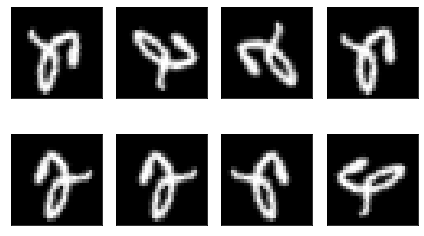

In [5]:
# Use just one image
X_train = np.reshape(8 * [X_train[5]], (8, 28, 28, 1))
y_train = 8 * [y_train[5]]

image_generator = ImageDataGenerator(rotation_range=100, horizontal_flip=True)
image_generator.fit(X_train)

for X_batch, y_batch in image_generator.flow(X_train, y_train, batch_size=8, seed=42):
  for i in range(0, 8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(X_batch[i].reshape(28, 28), cmap='gray')
    plt.xticks([], [])
    plt.yticks([], [])
  break

plt.tight_layout()
plt.show()

Together, fit_generator() and flow() manage the production of
batches of images, and presenting them to our model for training.

In [0]:
def make_cnn_model():
  model = Sequential()
  model.add(Conv2D(16, (5, 5), activation='relu', padding='same', kernel_constraint=max_norm(3), input_shape=(image_height, image_width, 1)))
  model.add(Dropout(0.2))
  model.add(Conv2D(8, (3, 3), activation='relu', padding='same', kernel_constraint=max_norm(3)))
  model.add(Dropout(0.2))
  model.add(Conv2D(8, (3, 3), activation='relu', padding='same', kernel_constraint=max_norm(3)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(number_of_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [11]:
# fit our model using images produced by the image generator
# ref: https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/
cnn_model = make_cnn_model()
cnn_history = cnn_model.fit_generator(
    image_generator.flow(X_train, y_train, batch_size=256), 
    validation_data=(X_test, y_test), epochs=100, steps_per_epoch=len(X_train) // 256)

  ...
    to  
  ['...']
Train for 1 steps, validate on 10000 samples
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 2.7102 - accuracy: 0.0000e+00 - val_loss: 2.3616 - val_accuracy: 0.1032
Epoch 2/100
1/1 [==============================] - 3s 3s/step - loss: 1.5499 - accuracy: 1.0000 - val_loss: 2.6908 - val_accuracy: 0.1032
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 0.6567 - accuracy: 1.0000 - val_loss: 3.8122 - val_accuracy: 0.1032
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.1339 - accuracy: 1.0000 - val_loss: 5.7150 - val_accuracy: 0.1032
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 0.0164 - accuracy: 1.0000 - val_loss: 7.8873 - val_accuracy: 0.1032
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 10.0885 - val_accuracy: 0.1032
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 1.1183e-04 - accuracy: 1.00

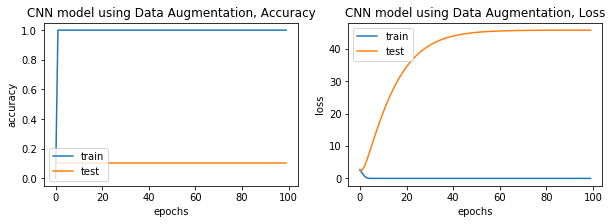

In [14]:
plot_accuracy_and_loss(cnn_history, 'CNN model using Data Augmentation')

## Synthetic Data